# Bin packing

Suppose that a set of items $N = \{1, \dots, n\}$ is given. Item $i \in N$ has size $a_i$, which is a positive integer. We would like to put the items into bins. Each bin has size $c$, which is also a positive integer. Suppose $n$ bins are available and $c \geq a_i$ for all $i \in N$. Each item should be put into exactly one bin, and the total size of items put in a bin should not exceed the size of the bin. The aim of the problem is to minimize the maximum empty space left in the used bins.

Let $x_{ij}$ be 1 if item $i \in N$ is put into bin $j \in N$, and 0 otherwise. Let $y_j$ be 1 if bin $j \in N$ is used and 0 otherwise. Let $z$ be the maximum empty space left. Using these variables, formulate an integer programming model for this problem.

Problem 1.2 from Mustafa Ç. Pınar's and  Deniz Akkaya's [Problems and Solutions for Integer and Combinatorial Optimization: Building Skills in Discrete Optimization](https://epubs.siam.org/doi/book/10.1137/1.9781611977769).


In [56]:
import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt
from typing import Tuple, Optional

#%matplotlib qt
%matplotlib inline

In [64]:
def make_items(n: int, size_range: Tuple[int, int], seed=0):
    """
    Function to generate a list of items for bin packing problem.

    Item sizes are randomly generated integers between 1 and s.
    
    Args:
        n (int): Number of items.
        size_range (Tuple[int, int]): Range of item sizes (min, max). Max is one more than the actual maximum value generated.
        seed (int): Random seed.

    Returns:
        np.array: Array of item sizes.
    
    """
    
    rnd = np.random.RandomState(seed)
    return rnd.randint(*size_range, n)

In [65]:
make_items(10, (4, 10), 0)

array([8, 9, 4, 7, 7, 7, 5, 7, 9, 6], dtype=int32)

In [30]:
def create_model(items: np.array, bin_size: int):
    """
    Function to create a Pyomo model of the bin packing problem.

    Args:
        items (np.array): Array of item sizes.
        bin_size (int): Size of the bins (all bins have the same size).

    Returns:
        pyo.ConcreteModel: Pyomo model of the problem.
    """
    
    # Check if bin size is greater or equal to the size of the largest item
    assert bin_size >= max(items), "Bin size should be greater or equal to the size of the largest item."

    model = pyo.ConcreteModel()
    
    model.I = range(len(items))
    model.J = range(len(items))
    
    model.x = pyo.Var(model.I, model.J, domain=pyo.Binary)
    model.y = pyo.Var(model.J, domain=pyo.Binary)
    model.z = pyo.Var(domain=pyo.NonNegativeReals)
    
    model.obj = pyo.Objective(expr=model.z, sense=pyo.minimize)
    
    # Item uniqueness constraint - each item should be put into exactly one bin
    model.c1 = pyo.ConstraintList()
    for i in model.I:
        model.c1.add(sum(model.x[i, j] for j in model.J) == 1)
    
    # Used bin constraint - if at least one item is put into a bin, the bin is used, and y[j] = 1
    model.c2 = pyo.ConstraintList()
    for j in model.J:
        model.c2.add(sum(model.x[i, j] for i in model.I) <= len(items) * model.y[j])
    
    # Bin capacity constraint - the total size of items put in a bin should not exceed the size of the bin
    model.c3 = pyo.ConstraintList()
    for j in model.J:
        model.c2.add(sum(items[i] * model.x[i, j] for i in model.I) <= bin_size * model.y[j])
    
    # Maximum empty space left constraint
    model.c4 = pyo.ConstraintList()
    for j in model.J:
        model.c3.add(bin_size * model.y[j] - sum(items[i] * model.x[i, j] for i in model.I) <= model.z)
        
    return model

In [32]:
a = make_items(10, (3, 6), 0)
a

array([3, 4, 3, 4, 4, 5, 3, 5, 3, 3], dtype=int32)

In [33]:
model = create_model(a, 8)

In [34]:
model.pprint()

3 Var Declarations
    x : Size=100, Index={0, 1, 2, 3, 4, 5, 6, 7, 8, 9}*{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :  None :     1 : False :  True : Binary
        (0, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 3) :     0 :  None :     1 : False :  True : Binary
        (0, 4) :     0 :  None :     1 : False :  True : Binary
        (0, 5) :     0 :  None :     1 : False :  True : Binary
        (0, 6) :     0 :  None :     1 : False :  True : Binary
        (0, 7) :     0 :  None :     1 : False :  True : Binary
        (0, 8) :     0 :  None :     1 : False :  True : Binary
        (0, 9) :     0 :  None :     1 : False :  True : Binary
        (1, 0) :     0 :  None :     1 : False :  True : Binary
        (1, 1) :     0 :  None :     1 : False :  True : Binary
        (1, 2) :     0 :  None :     1 : False :  True : Binary

In [35]:
results = pyo.SolverFactory('cbc').solve(model)

In [39]:
def bin_packing_solution(model):
    """
    Function to show the bin packing solution as a list of items in each bin.

    Args:
        model (pyo.ConcreteModel): Pyomo model of the problem.

    Returns:
        list: List of items in each bin. Each item is represented by its index (not size).
    
    """
    
    bins = []
    for j in model.J:
        bin_items = []
        for i in model.I:
            if pyo.value(model.x[i, j]) == 1:
                bin_items.append(i)
        bins.append(bin_items)
    
    return bins

In [40]:
bin_packing_solution(model)

[[], [1, 8], [7, 9], [], [5, 6], [0, 4], [], [2, 3], [], []]

In [75]:
def bin_packing_plot(model, problem: np.array, bin_size: Optional[int] = None, figsize=(8, 5)):
    """
    Function to show the bin packing solution as a stacked bar plot.

    Each bar represents a bin, and different items are colored differently and stacked on top of each other.

    Args:
        model (pyo.ConcreteModel): solved Pyomo model of the problem.
        problem (np.array): Array of item sizes. Used to get the size of each item.
        bin_size (int): Size of the bins. Used to draw the size of the bins.
        figsize (Tuple[int, int]): Size of the plot.

    Returns:
        None
    
    """
    
    bins = [[] for _ in model.J]
    for j in model.J:
        for i in model.I:
            if pyo.value(model.x[i, j]) == 1:
                bins[j].append(i)
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(bins)))
    fig, ax = plt.subplots(figsize=figsize)
    for j, bin_items in enumerate(bins):
        bottom = 0
        for item in bin_items:
            ax.bar(j, problem[item], bottom=bottom, color=colors[item], label=f'Item {item}' if bottom == 0 else "")
            bottom += problem[item]
    if bin_size:
        ax.axhline(y=bin_size, color='r', linestyle='--', alpha=0.5, label=f'Bin size = {bin_size}')
    
    # set x-axis to only show major ticks
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.set_title('Bin Packing Solution')
    plt.show()

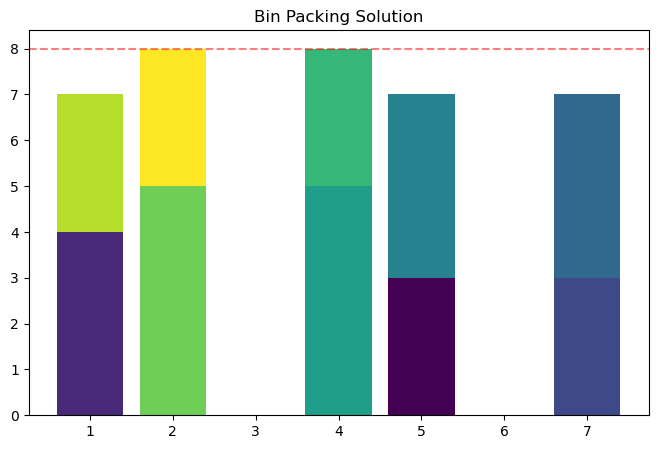

In [77]:
bin_packing_plot(model, a, 8)

In [78]:
def pack_and_plot_bins(items: np.array, bin_size: int, figsize=(8, 5), solver='cbc'):
    """
    Function to solve the bin packing problem and plot the solution.

    Args:
        items (np.array): Array of item sizes.
        bin_size (int): Size of the bins.
        figsize (Tuple[int, int]): Size of the plot.

    Returns:
        None
    
    """
    
    model = create_model(items, bin_size)
    pyo.SolverFactory(solver).solve(model)
    bin_packing_plot(model, items, bin_size, figsize)

In [79]:
bins1 = make_items(10, (1, 3), 0)
bins1

array([1, 2, 2, 1, 2, 2, 2, 2, 2, 2], dtype=int32)

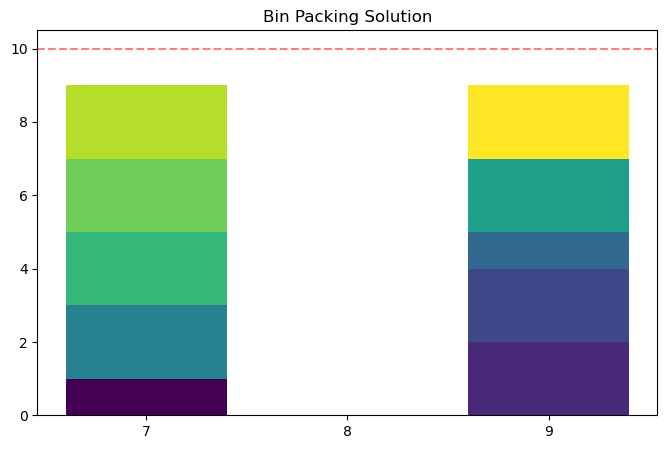

In [80]:
pack_and_plot_bins(bins1, 10)